### Introduction

We want to do some analysis of Major League Baseball games. Some of the questions we might like to answer include:

* How many games have ended up with more than 20 runs scored?
* What's the average number of hits per game, and how does that vary by stadium?
* How important was this play to the outcome of the game?

Lots of interesting questions, and of course that starts with data. Some of these questions are already answerable via paid services online, while others would be much harder to find. But they don't have to be difficult! In this notebook, we will construct a queryable dataset with *every event* happening in *every MLB game* for the last decade. We'll know who was batting, who was pitching, what happened, and how that game turned out.

While we generally say that data cleaning is 80% of data science, it's not in this case. That's thanks to the wonderful volunteers at Retrosheet, who make play-by-play baseball data available all the way back to 1918! We are going to use their incredible data, and just finagle it a bit to make it easier to work with. The code is a bit tricky to follow - we need to bounce between shell scripts, Python, and SQL statements, so bear with me.

#### Prerequisites
* I will assume that the reader has downloaded one or more years of the data here: https://www.retrosheet.org/game.htm
* I will assume you have downloaded BGAME.EXE and BEVENT.EXE here: https://www.retrosheet.org/tools.htm
* I will also assume that you have a working PostgreSQL server running on your machine. If not, download pgAdmin here and set one up: https://www.pgadmin.org/download/
* The script expect that the datasets, and these EXE files, are located in the same directory. Obviously you dont have to, just change the code.

#### What will we do here?
This script will "process" the Retrosheets raw data into a nice tabular format, with dozens of columns. (Try BGAME.EXE -h to see some of the columns available.) We'll do a small amount of data cleaning, and then save those to tables in our Postgres server. We'll show some example queries at the end.

#### Mac users
I use a Windows machine at home, so the script assumes Windows. Its likely not much work to change over, but I dont have a Mac to test it on.


In [1]:
import os
import sys
import numpy as np
import pandas as pd
import pickle
from sqlalchemy import create_engine
import time
from credentials import BASEBALL_DB_NAME, BASEBALL_DB_PWD
from plotnine import *

In [2]:
PATH_TO_DATA = 'C:/Users/Chuck/Desktop/Baseball Data/baseball_data/raw_data/'
os.chdir(PATH_TO_DATA)
all_files = os.listdir()
all_files = [x for x in all_files if '.EV' in x]
all_files = [x for x in all_files if ('2010' not in x) and ('2011' not in x)]
all_files.sort()

all_files[:5]

['2012ANA.EVA', '2012ARI.EVN', '2012ATL.EVN', '2012BAL.EVA', '2012BOS.EVA']

We'll create two tables. *game_data* is for game-level data (which team won, for example). You'll have one entry per game.

*event_data* is for play-level data (what was the outcome of a particular at-bat). This will have dozens of entries per game, one for every event that takes place in the game.

Let's connect to the PostgreSQL server, and do some cleanup.

#### Game dataset

In [3]:
engine = create_engine('postgresql://baseball:{}@localhost:5432/{}'.format(BASEBALL_DB_PWD, BASEBALL_DB_NAME))

res = engine.execute("DROP TABLE IF EXISTS game_data cascade")
res.close()

res = engine.execute("DROP TABLE IF EXISTS event_data cascade")
res.close()


Due to the way the retrosheets data is set up, we have to process one file at a time. The command is also pretty unwieldy! 

To make this easier, we'll make a little function doing all the data processing, and call it on each file.

In [4]:
start = time.time()

game_data_columns = ['game_id', 'date', 'day_of_week', 'day_night', 'visitor', 'home', 'game_site'
                     , 'vis_pitcher', 'hom_pitcher', 'temperature', 'wind_dir', 'wind_sp'
                     , 'field_cond', 'precipitation', 'sky', 'vis_score', 'hom_score'
                     , 'winning_pitcher', 'losing_pitcher'] + [a + b + str(c) for a in ['vis', 'hom'] for c in range(1, 10) for b in ['Batter']]

def processGameFile(path):
    year = path[:4]
    os.system('BGAME.EXE -y {} -f 0-1,3,6-11,26-31,34-35,42-43,46,48,50,52,54,56,58,60,62,64,66,68,70,72,74,76,78,80 {} > tmp.txt'.format(year, path))
    temp = pd.read_csv('tmp.txt', header=None)
    temp.columns = game_data_columns
    temp['date'] = pd.to_datetime(temp['date'], format = '%y%m%d')
    temp.to_sql('game_data', con = engine, index = False, if_exists = 'append')
    
res = [processGameFile(x) for x in all_files]

print('Processed {} files in {} seconds'.format(len(all_files), round(time.time() - start)))

Processed 300 files in 18 seconds


In [5]:
pd.read_sql("SELECT * FROM game_data limit 100;", engine)

,game_id,date,day_of_week,day_night,visitor,home,game_site,vis_pitcher,hom_pitcher,temperature,...,visBatter9,homBatter1,homBatter2,homBatter3,homBatter4,homBatter5,homBatter6,homBatter7,homBatter8,homBatter9
0,ANA201204060,2012-04-06,Friday,N,KCA,ANA,ANA01,chenb001,weavj003,69,...,escoa003,aybae001,kendh001,pujoa001,huntt001,wellv001,morak001,trumm001,iannc001,bourp001
1,ANA201204070,2012-04-07,Saturday,D,KCA,ANA,ANA01,hochl001,hared001,85,...,escoa003,aybae001,kendh001,pujoa001,morak001,huntt001,abreb001,wellv001,calla001,wilsb002
2,ANA201204080,2012-04-08,Sunday,D,KCA,ANA,ANA01,sancj002,sante001,80,...,getzc001,aybae001,kendh001,pujoa001,huntt001,wellv001,morak001,trumm001,iannc001,bourp001
3,ANA201204160,2012-04-16,Monday,N,OAK,ANA,ANA01,mccab001,weavj003,71,...,sogae001,aybae001,kendh001,pujoa001,morak001,huntt001,wellv001,iztum001,iannc001,bourp001
4,ANA201204170,2012-04-17,Tuesday,N,OAK,ANA,ANA01,rosst001,hared001,72,...,pennc001,aybae001,kendh001,pujoa001,morak001,huntt001,wellv001,calla001,iannc001,bourp001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,ARI201205080,2012-05-08,Tuesday,N,SLN,ARI,PHO01,westj001,kenni001,90,...,westj001,parrg001,hilla001,uptoj001,montm001,goldp001,kubej002,ransc001,mcdoj003,kenni001
96,ARI201205090,2012-05-09,Wednesday,N,SLN,ARI,PHO01,lohsk001,milew001,78,...,lohsk001,parrg001,bloow001,uptoj001,montm001,kubej002,hilla001,overl001,rober002,milew001
97,ARI201205110,2012-05-11,Friday,N,SFN,ARI,PHO01,bumgm001,corbp001,95,...,bumgm001,bloow001,hilla001,uptoj001,montm001,goldp001,rober002,parrg001,polla001,corbp001
98,ARI201205120,2012-05-12,Saturday,N,SFN,ARI,PHO01,cainm001,cahit001,78,...,cainm001,bloow001,parrg001,uptoj001,montm001,rober002,overl001,kubej002,hilla001,cahit001


#### Event dataset

In [6]:
start = time.time()
event_data_columns = ['game_id', 'visitor', 'inning', 'batting_team', 'outs', 'balls', 'strikes', 'vis_score', 'hom_score'
                      , 'batter', 'batter_hand', 'pitcher', 'pitcher_hand', 'runner_1b', 'runner_2b', 'runner_3b'
                      , 'event_text', 'event_type', 'batter_event_flag', 'ab_flag', 'hit_value', 'outs_on_play', 'rbi_flag'
                      , 'batter_dest', "event_num"]

def processEventFile(path):
    year = path[:4]
    os.system('BEVENT.EXE -y {} -f 0-6,8-9,12-13,16-17,26-28,29,34,35-37,40,43,58,96 {} > tmp.txt'.format(year, path))
    temp = pd.read_csv('tmp.txt', header=None)
    temp.columns = event_data_columns
    temp.to_sql('event_data', con=engine, index= False, if_exists = 'append')
    
res = [processEventFile(x) for x in all_files]

print('Processed {} files in {} seconds'.format(len(all_files), round(time.time() - start)))

Processed 300 files in 118 seconds


In [7]:
pd.read_sql("SELECT * FROM event_data limit 100;", engine)

,game_id,visitor,inning,batting_team,outs,balls,strikes,vis_score,hom_score,batter,...,runner_3b,event_text,event_type,batter_event_flag,ab_flag,hit_value,outs_on_play,rbi_flag,batter_dest,event_num
0,ANA201204060,KCA,1,0,0,1,1,0,0,gorda001,...,None,8/F,2,T,T,0,1,0,0,1
1,ANA201204060,KCA,1,0,1,2,2,0,0,cainl001,...,None,K,3,T,T,0,1,0,0,2
2,ANA201204060,KCA,1,0,2,1,0,0,0,hosme001,...,None,7/F,2,T,T,0,1,0,0,3
3,ANA201204060,KCA,1,1,0,0,0,0,0,aybae001,...,None,13/BG,2,T,T,0,1,0,0,4
4,ANA201204060,KCA,1,1,1,0,2,0,0,kendh001,...,None,D8/F,21,T,T,2,0,0,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,ANA201204070,KCA,4,0,0,1,2,3,0,escoa003,...,None,K,3,T,T,0,1,0,0,30
96,ANA201204070,KCA,4,0,1,0,0,3,0,gorda001,...,None,3/P3F,2,T,T,0,1,0,0,31
97,ANA201204070,KCA,4,0,2,3,2,3,0,cainl001,...,None,K,3,T,T,0,1,0,0,32
98,ANA201204070,KCA,4,1,0,1,1,3,0,kendh001,...,None,53/G-,2,T,T,0,1,0,0,33


#### Player names

Let's make a convenience table with the name of each player, rather than their ID. This is also sourced from Retrosheet

In [8]:
player_names = pd.read_csv('../player_mapping_file.csv')

player_names.to_sql('player_names', con = engine, index = False, if_exists = 'replace')

284

#### Examples

*How many games have ended up with more than 20 runs scored?* That is now super easy to answer! It's below.

Indeed, we can do much more as well. We also show below the distribution of home and away scores for all games in the period. For the most part, games tend to end around 4 - 3 or so. But there are a few extreme values of both ends.

In [9]:
pd.read_sql("SELECT * FROM game_data WHERE (hom_score + vis_score) > 20;", engine)

,game_id,date,day_of_week,day_night,visitor,home,game_site,vis_pitcher,hom_pitcher,temperature,...,visBatter9,homBatter1,homBatter2,homBatter3,homBatter4,homBatter5,homBatter6,homBatter7,homBatter8,homBatter9
0,ARI201206190,2012-06-19,Tuesday,N,SEA,ARI,PHO01,ramie004,hudsd001,81,...,ramie004,bloow001,hilla001,uptoj001,kubej002,goldp001,montm001,bellj004,parrg001,hudsd001
1,ARI201206200,2012-06-20,Wednesday,D,SEA,ARI,PHO01,vargj001,cahit001,77,...,vargj001,younc004,hilla001,uptoj001,kubej002,goldp001,montm001,rober002,mcdoj003,cahit001
2,ARI201207200,2012-07-20,Friday,N,HOU,ARI,PHO01,norrb001,cahit001,80,...,norrb001,parrg001,drews001,hilla001,kubej002,uptoj001,montm001,goldp001,wheer001,cahit001
3,ATL201205020,2012-05-02,Wednesday,N,PHI,ATL,ATL02,hallr001,hanst001,87,...,hallr001,bourm001,pradm001,freef001,mccab002,uggld001,jonec004,hinse001,pastt001,hanst001
4,BAL201207270,2012-07-27,Friday,N,OAK,BAL,BAL12,parkj001,britz001,88,...,weekj001,markn001,hardj003,thomj002,jonea003,davic003,betew001,reynm001,quino001,teagt001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,TOR202105240,2021-05-24,Monday,D,TBA,TOR,DUN01,yarbr001,thort002,85,...,kierk001,semim001,bichb001,guerv002,hernt002,gricr001,gurrl001,espis001,davij007,mcgur002
353,TOR202109030,2021-09-03,Friday,N,OAK,TOR,TOR02,manas001,manoa001,69,...,andre001,sprig001,semim001,guerv002,bichb001,hernt002,kirka001,gurrl001,gricr001,smitk003
354,WAS202105220,2021-05-22,Saturday,D,BAL,WAS,WAS11,zimmb002,lestj001,86,...,zimmb002,turnt001,sotoj001,zimmr001,casts001,schwk001,harrj002,gomey001,mercj002,lestj001
355,WAS202106300,2021-06-30,Wednesday,D,TBA,WAS,WAS11,rasmd002,lestj001,95,...,rasmd002,schwk001,turnt001,sotoj001,bellj005,gomey001,casts001,parrg001,mercj002,lestj001


In [10]:
all_scores = pd.read_sql("SELECT hom_score, vis_score, SUM(1) AS num_games FROM game_data GROUP BY 1, 2;", engine)

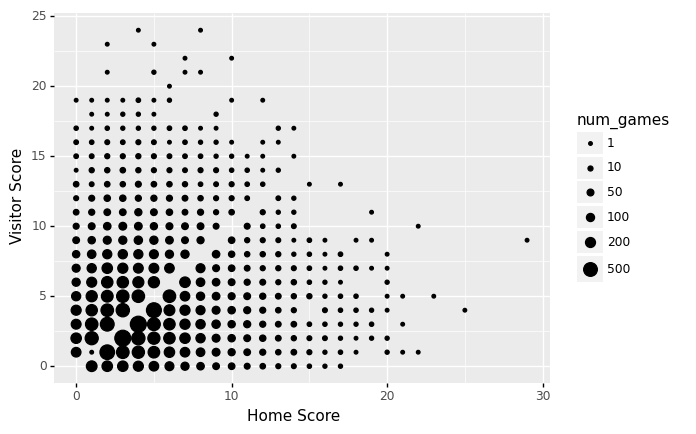

<ggplot: (103218396916)>

In [11]:
from plotnine import *
ggplot(aes(x = 'hom_score', y = 'vis_score', size = 'num_games'), data = all_scores) +\
geom_point() + scale_size_continuous(breaks = [1, 10, 50, 100, 200, 500]) + ylab("Visitor Score") + xlab("Home Score")

*What's the average number of hits per game, and how does that vary by stadium?*

In [12]:
hits_data = pd.read_sql("SELECT e.game_id, g.game_site, SUM(CASE WHEN hit_value >= 1 THEN 1 ELSE 0 END) AS hits FROM event_data e INNER JOIN game_data g ON e.game_id = g.game_id GROUP BY 1, 2;", engine)

hits_data.agg({'hits': ['mean', 'count']})

,hits
mean,17.102043
count,22765.000000


Notably, there's some variation across ballparks as well. Lowest is STP01 (Tropicana Field, for the Tampa Bay Rays), and highest is DEN02 (Coors Field, for the Colorado Rockies). Games played at Coors Field have, on average, 5 more hits per game than games played at Tropicana Field.

Comfortingly, this data seems aligned with other, more reputable "park factor" datasets. Looking at ESPN's park factors for 2021, Coors Field has the second highest hit rate, while Tropicana Field has the second lowest. https://www.espn.com/mlb/stats/parkfactor/_/year/2021/sort/hitsFactor

So with a minimal amount of effort, we've constructed a metric that seems aligned with fairly sophisticated ESPN models - all with fully open source data. 

(Note of course, this could be because of the stadium, or because the team playing in that stadium is unusually good or bad at getting hits. This is just exploratory thus far.)

In [13]:
hits_by_location = hits_data.groupby('game_site').agg({'hits': ['mean', 'count']}).reset_index()
hits_by_location.columns = ['_'.join(col).rstrip('_') for col in hits_by_location.columns.values]

hits_by_location.query('hits_count > 300').sort_values('hits_mean')

,game_site,hits_mean,hits_count
37,STP01,15.791064,761
25,NYC20,15.864652,761
20,LOS03,15.892105,760
32,SAN02,15.981530,758
33,SEA03,16.124834,753
8,CHI11,16.325033,763
27,OAK01,16.416337,759
17,HOU03,16.599469,754
22,MIL06,16.633377,761
21,MIA02,16.640479,751
